In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'AppleGothic'


In [3]:
# 파일 읽기
nonhyun_df = pd.read_csv("논현로_통행속도_기상.csv", encoding='cp949')

# 결측치 확인 
print('논현로 결측치 수 : ',nonhyun_df['속도'].isna().sum())

논현로 결측치 수 :  1047


In [4]:
nonhyun_df.keys()

array(['금', '토', '일', '월', '화', '수', '목'], dtype=object)

In [14]:
# nonhyun_df.drop(columns = ['일자', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)

In [5]:
def fill_missing_values(df):
    # 일시 컬럼을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 추출
    df['hour'] = df['일시'].dt.hour
    
    # 각 결측치에 대해
    null_indices = df[df['속도'].isnull()].index
    
    for idx in null_indices:
        current_row = df.loc[idx]
        
        # 현재 결측치의 조건과 동일한 데이터 필터링
        same_conditions = (
            (df['링크아이디'] == current_row['링크아이디']) & 
            (df['hour'] == current_row['hour']) & 
            (df['isHoliday'] == current_row['isHoliday']) &
            (df['속도'].notnull())  # 결측치가 아닌 데이터만
        )
        
        # 조건에 맞는 평균 속도 계산
        mean_speed = df[same_conditions]['속도'].mean()
        
        # 만약 조건에 맞는 데이터가 없다면 (mean_speed가 NaN이라면)
        # 휴일 조건을 제외하고 다시 계산
        if pd.isna(mean_speed):
            same_conditions = (
                (df['링크아이디'] == current_row['링크아이디']) & 
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 여전히 평균을 구할 수 없다면 전체 링크아이디의 해당 시간대 평균 사용
        if pd.isna(mean_speed):
            same_conditions = (
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 결측치 채우기
        df.loc[idx, '속도'] = mean_speed
        
    return df

# 사용 예시:
nonhyun_df = fill_missing_values(nonhyun_df.copy())

print('논현로 결측치 수 : ',nonhyun_df['속도'].isna().sum())

논현로 결측치 수 :  0


### 이상치 제거

논현로 이상치 제거 전: 666216 후: 610622


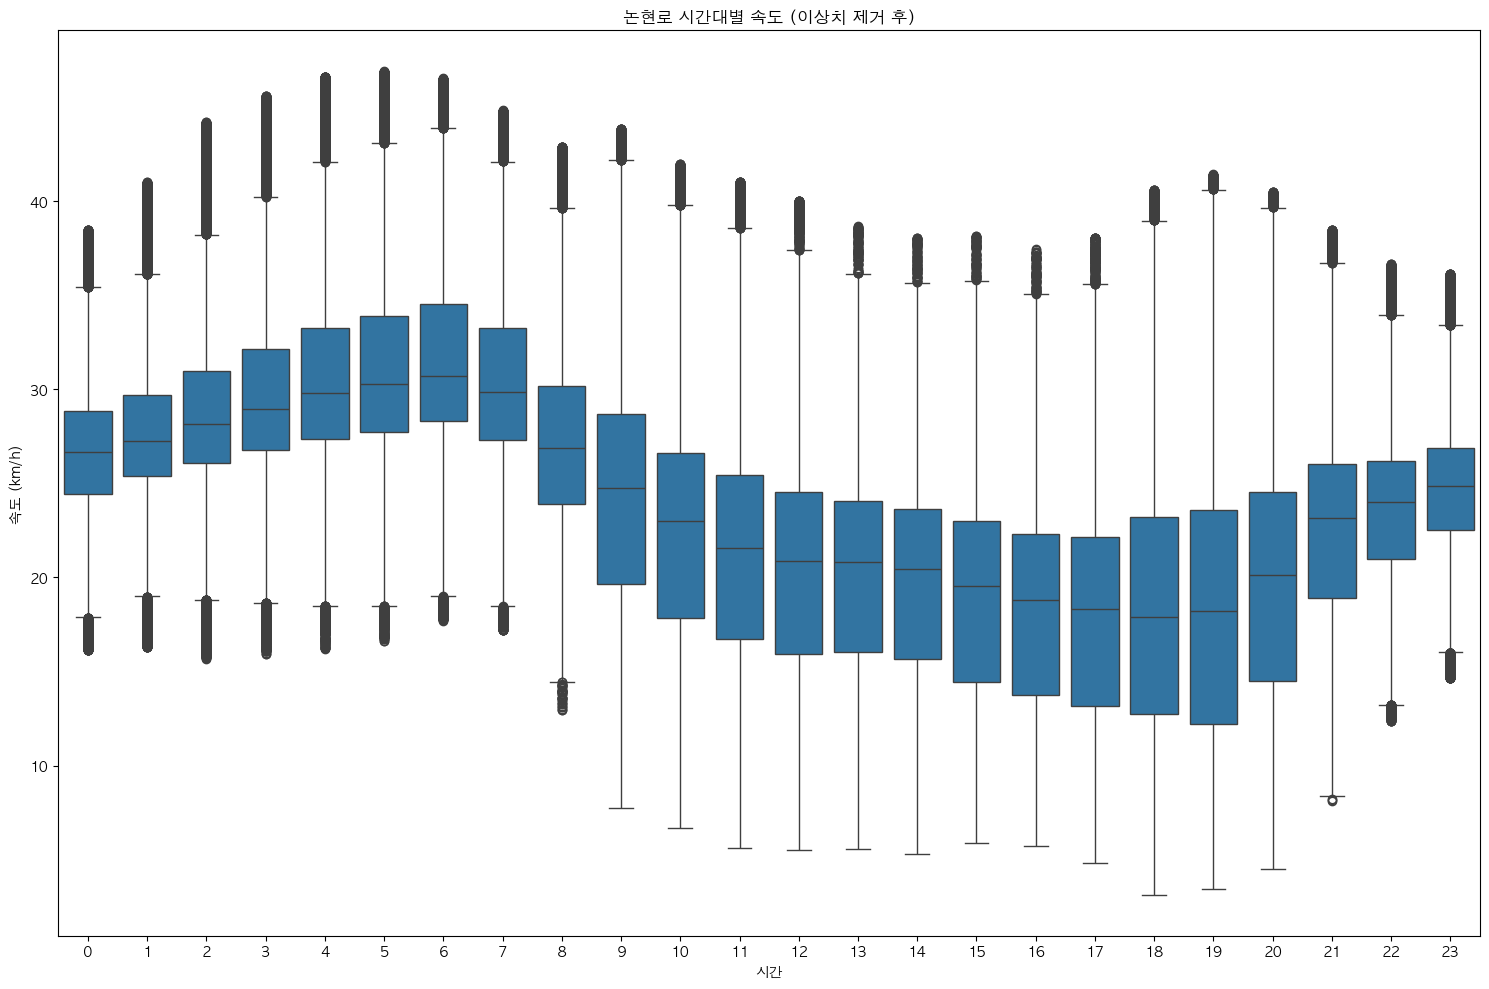


[논현로 시간대별 속도 통계값 (이상치 제거 후)]
        count       mean       std    min      25%     50%      75%    max
hour                                                                      
0     24157.0  26.714480  4.077494  16.14  24.4600  26.650  28.8500  38.49
1     24595.0  27.783212  4.205721  16.30  25.4100  27.280  29.6900  41.01
2     25154.0  28.705786  5.046624  15.67  26.1000  28.160  30.9500  44.18
3     25247.0  29.558559  5.295784  15.94  26.7500  28.970  32.1400  45.57
4     25462.0  30.401159  5.487014  16.22  27.3500  29.790  33.2500  46.61
5     25640.0  30.906568  5.649180  16.63  27.7175  30.290  33.8700  46.89
6     25843.0  31.444019  5.144219  17.71  28.3300  30.700  34.5500  46.53
7     25663.0  30.325837  5.007963  17.20  27.3300  29.870  33.2400  44.82
8     25394.0  27.470985  5.351656  12.94  23.8900  26.895  30.1875  42.87
9     26581.0  24.833989  7.013104   7.75  19.6700  24.730  28.6700  43.83
10    25939.0  22.725863  7.052222   6.69  17.8600  23.000  26.6250  4

In [6]:
# 각 도로별 이상치 제거 기준 설정 및 제거
def remove_outliers(df):
    # 시간대별로 그룹화하여 이상치 제거
    df_clean = pd.DataFrame()
    
    for hour in df['hour'].unique():
        # 해당 시간대 데이터 추출
        hour_data = df[df['hour'] == hour].copy()
        
        # 해당 시간대의 IQR 계산
        Q1 = hour_data['속도'].quantile(0.25)
        Q3 = hour_data['속도'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        hour_data_clean = hour_data[(hour_data['속도'] >= lower_bound) & 
                                  (hour_data['속도'] <= upper_bound)]
        
        # 정제된 데이터 추가
        df_clean = pd.concat([df_clean, hour_data_clean])
    
    return df_clean

# 논현로 이상치 제거
nonhyun_df_clean = remove_outliers(nonhyun_df.copy())

# 이상치 제거 전후 데이터 수 비교
print('논현로 이상치 제거 전:', len(nonhyun_df), '후:', len(nonhyun_df_clean))

# 이상치 제거 후 박스플롯 시각화
plt.figure(figsize=(15, 10))

# 논현로 시간대별 이상치
sns.boxplot(data=nonhyun_df_clean, x='hour', y='속도')
plt.title('논현로 시간대별 속도 (이상치 제거 후)', fontsize=12)
plt.xlabel('시간')
plt.ylabel('속도 (km/h)')

plt.tight_layout()
plt.show()

# 이상치 제거 후 통계값 출력
print("\n[논현로 시간대별 속도 통계값 (이상치 제거 후)]")
print(nonhyun_df_clean.groupby('hour')['속도'].describe())


### 피쳐 중요도 확인

/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== 상관관계 분석 ===


/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


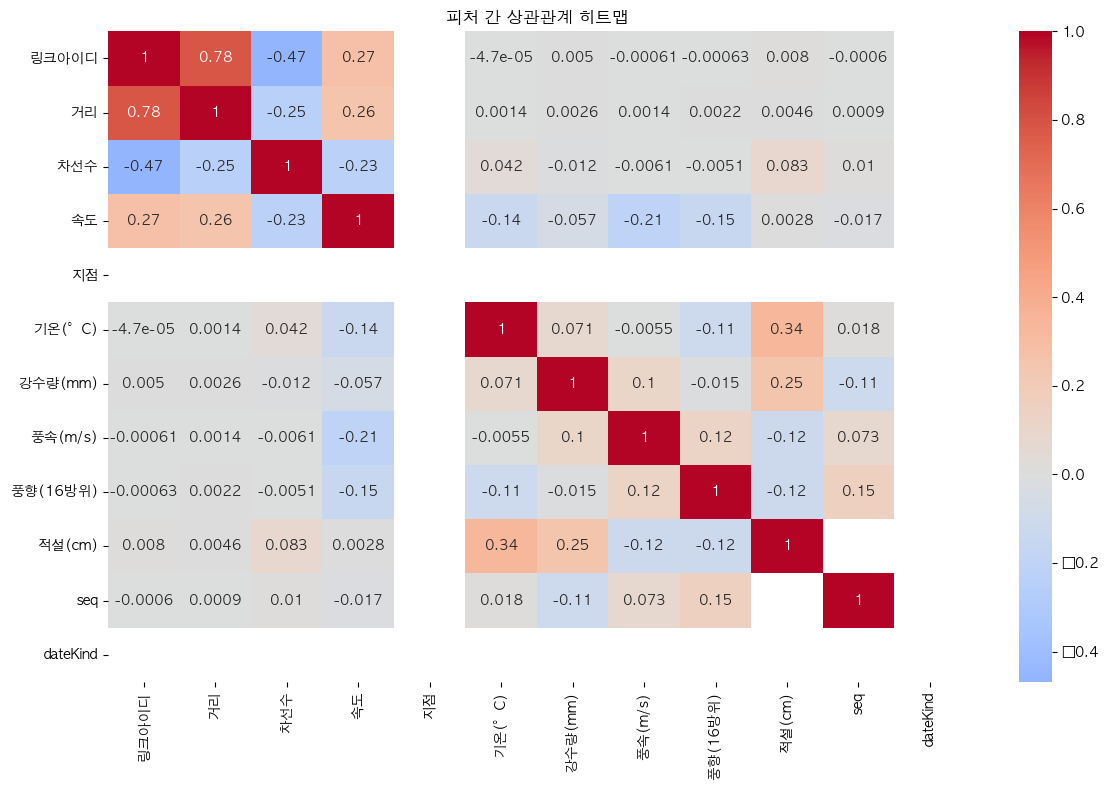


속도와의 상관관계 (절대값 기준):
속도          1.000000
링크아이디       0.273913
거리          0.255795
차선수         0.232069
풍속(m/s)     0.205709
풍향(16방위)    0.148005
기온(°C)      0.139491
강수량(mm)     0.056752
seq         0.017353
적설(cm)      0.002805
지점               NaN
dateKind         NaN
Name: 속도, dtype: float64

=== Random Forest 기반 중요도 분석 ===


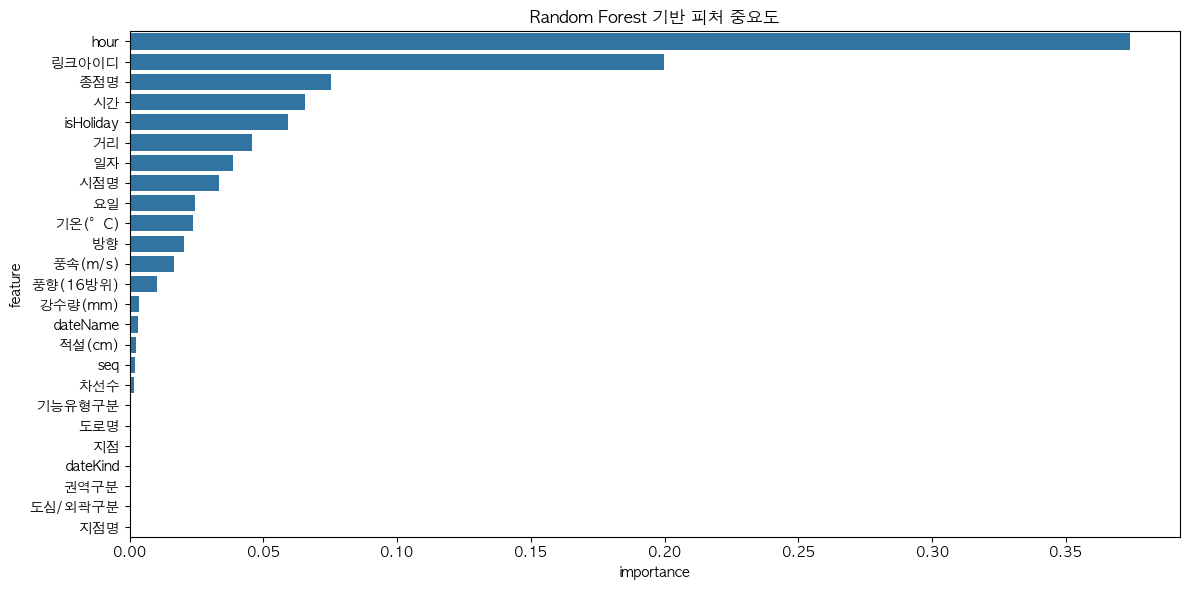


Random Forest 기반 피처 중요도:
      feature  importance
24       hour    0.373917
3       링크아이디    0.199746
5         종점명    0.075366
12         시간    0.065635
22  isHoliday    0.059315
7          거리    0.045619
0          일자    0.038624
4         시점명    0.033534
1          요일    0.024524
15     기온(°C)    0.023570
6          방향    0.020373
17    풍속(m/s)    0.016466
18   풍향(16방위)    0.010286
16    강수량(mm)    0.003641
23   dateName    0.003164
19     적설(cm)    0.002534
20        seq    0.002140
8         차선수    0.001547
9      기능유형구분    0.000000
2         도로명    0.000000
13         지점    0.000000
21   dateKind    0.000000
11       권역구분    0.000000
10    도심/외곽구분    0.000000
14        지점명    0.000000

=== SHAP 값 기반 중요도 분석 ===


In [ ]:
# 1. 상관관계 분석
def analyze_feature_importance(df):
    # 수치형 컬럼만 선택
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # 상관관계 분석
    correlation_matrix = df[numeric_columns].corr()
    
    # 속도와의 상관관계만 추출하고 절대값 기준으로 정렬
    speed_correlation = correlation_matrix['속도'].abs().sort_values(ascending=False)
    
    # 상관관계 히트맵 시각화
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('피처 간 상관관계 히트맵')
    plt.tight_layout()
    plt.show()
    
    print("\n속도와의 상관관계 (절대값 기준):")
    print(speed_correlation)
    
    return correlation_matrix

# 2. Random Forest를 이용한 피처 중요도 분석
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def analyze_rf_importance(df):
    # 범주형 변수 인코딩
    le = LabelEncoder()
    df_encoded = df.copy()
    
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df_encoded[col] = le.fit_transform(df[col])
    
    # 피처와 타겟 분리
    X = df_encoded.drop(['속도', '일시'], axis=1)  # '일시' 컬럼 제외
    y = df_encoded['속도']
    
    # Random Forest 모델 학습
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # 피처 중요도 계산
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 피처 중요도 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Random Forest 기반 피처 중요도')
    plt.tight_layout()
    plt.show()
    
    print("\nRandom Forest 기반 피처 중요도:")
    print(importance_df)
    
    return importance_df

# 3. SHAP 값을 이용한 피처 중요도 분석
import shap

def analyze_shap_importance(df):
    # 범주형 변수 인코딩
    le = LabelEncoder()
    df_encoded = df.copy()
    
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df_encoded[col] = le.fit_transform(df[col])
    
    # 피처와 타겟 분리
    X = df_encoded.drop(['속도', '일시'], axis=1)
    y = df_encoded['속도']
    
    # Random Forest 모델 학습
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # SHAP 값 계산
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X)
    
    # SHAP 값 시각화
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar")
    plt.title('SHAP 값 기반 피처 중요도')
    plt.tight_layout()
    
    return shap_values, X

# 분석 실행
print("=== 상관관계 분석 ===")
corr_matrix = analyze_feature_importance(nonhyun_df_clean)

print("\n=== Random Forest 기반 중요도 분석 ===")
rf_importance = analyze_rf_importance(nonhyun_df_clean)

print("\n=== SHAP 값 기반 중요도 분석 ===")
shap_values, X = analyze_shap_importance(nonhyun_df_clean)

### 모델 돌리기

In [ ]:
def train_lstm_model(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    LSTM 모델을 학습하고 예측하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        입력 데이터프레임
    target_col : str 
        예측하고자 하는 타겟 컬럼명
    time_steps : int
        시계열 데이터의 시간 스텝 (기본값: 24)
    train_ratio : float
        학습 데이터 비율 (기본값: 0.8)
    epochs : int
        학습 에포크 수 (기본값: 50)
    batch_size : int
        배치 크기 (기본값: 32)
    """
    
    unique_links = df['링크아이디'].unique()
    results = {}
    predictions_df = pd.DataFrame()
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id]
        
        # 데이터 전처리
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(link_df[target_col].values.reshape(-1,1))

        # 시계열 데이터셋 생성
        def create_dataset(data, time_steps=1):
            X, y = [], []
            for i in range(len(data) - time_steps):
                X.append(data[i:(i + time_steps), 0])
                y.append(data[i + time_steps, 0])
            return np.array(X), np.array(y)

        # 시계열 데이터 생성
        X, y = create_dataset(scaled_data, time_steps)

        # 학습/테스트 데이터 분할
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # 데이터 reshape (LSTM 입력 형태로)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # LSTM 모델 구성
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
            LSTM(50, activation='relu'),
            Dense(1)
        ])

        # 모델 컴파일
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0)

        # 예측
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 예측값 역변환
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inv = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test_inv = scaler.inverse_transform([y_test])
        
        # 24시간 미래 예측
        last_sequence = scaled_data[-time_steps:]
        future_predictions = []
        
        current_sequence = last_sequence.reshape((1, time_steps, 1))
        for _ in range(24):  # 24시간 예측
            next_pred = model.predict(current_sequence)
            future_predictions.append(next_pred[0,0])
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[0,-1,0] = next_pred[0,0]
            
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        
        # 예측 결과를 DataFrame에 추가
        temp_df = pd.DataFrame({
            '링크아이디': [link_id] * 24,
            'hour': range(24),
            '예측속도': future_predictions.flatten()
        })
        predictions_df = pd.concat([predictions_df, temp_df])

        # 결과 시각화
        plt.figure(figsize=(15,6))
        plt.plot(y_test_inv.T, label='실제값')
        plt.plot(test_predict, label='예측값')
        plt.title(f'{name} 링크 {link_id} {target_col} 예측 결과')
        plt.xlabel('시간')
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # 모델 평가 결과 저장
        results[link_id] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'Train RMSE': np.sqrt(mean_squared_error(y_train_inv.T, train_predict)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test_inv.T, test_predict)),
                'Train MAE': mean_absolute_error(y_train_inv.T, train_predict),
                'Test MAE': mean_absolute_error(y_test_inv.T, test_predict),
                'Train R2': r2_score(y_train_inv.T, train_predict),
                'Test R2': r2_score(y_test_inv.T, test_predict),
                'Train Adjusted R2': 1 - (1-r2_score(y_train_inv.T, train_predict))*(len(y_train_inv.T)-1)/(len(y_train_inv.T)-X_train.shape[2]-1),
                'Test Adjusted R2': 1 - (1-r2_score(y_test_inv.T, test_predict))*(len(y_test_inv.T)-1)/(len(y_test_inv.T)-X_test.shape[2]-1)
            }
        }
        
        # 평가 결과 출력
        print(f'{name}의 링크 {link_id} 평가 결과:')
        for metric, value in results[link_id]['metrics'].items():
            print(f'{metric}: {value}')
        print('-' * 50)
    
    # 예측 결과를 CSV 파일로 저장
    predictions_df.to_csv(f'{name}_이상치제거_{target_col}_predictions.csv', index=False)
    return results, predictions_df

### 모델 결과

In [ ]:
results_gaepo = train_lstm_model(nonhyun_df_clean,'이상치 제거한 논현로df', target_col='속도')

### 공휴일 구분한 모델 학습


링크아이디 1220022900에 대한 분석

평일 데이터 분석 중... (데이터 수: 23697)

평일 평가 결과:
RMSE: 2.49
MAE: 2.01


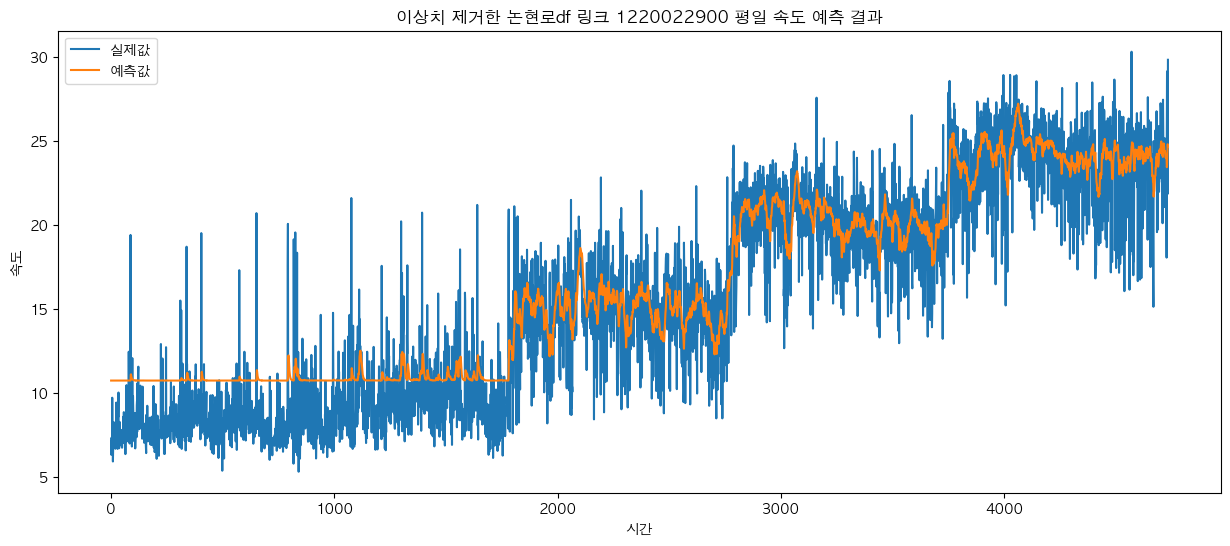


휴일 데이터 분석 중... (데이터 수: 11328)

휴일 평가 결과:
RMSE: 2.90
MAE: 2.13


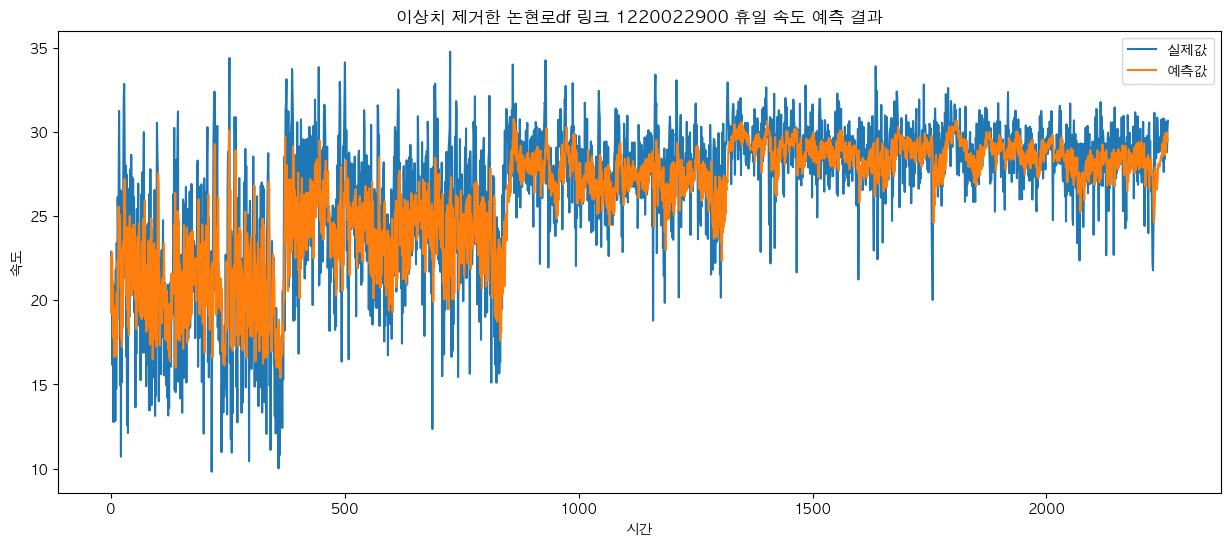


링크아이디 1220019800에 대한 분석

평일 데이터 분석 중... (데이터 수: 23643)

평일 평가 결과:
RMSE: 1.90
MAE: 1.46


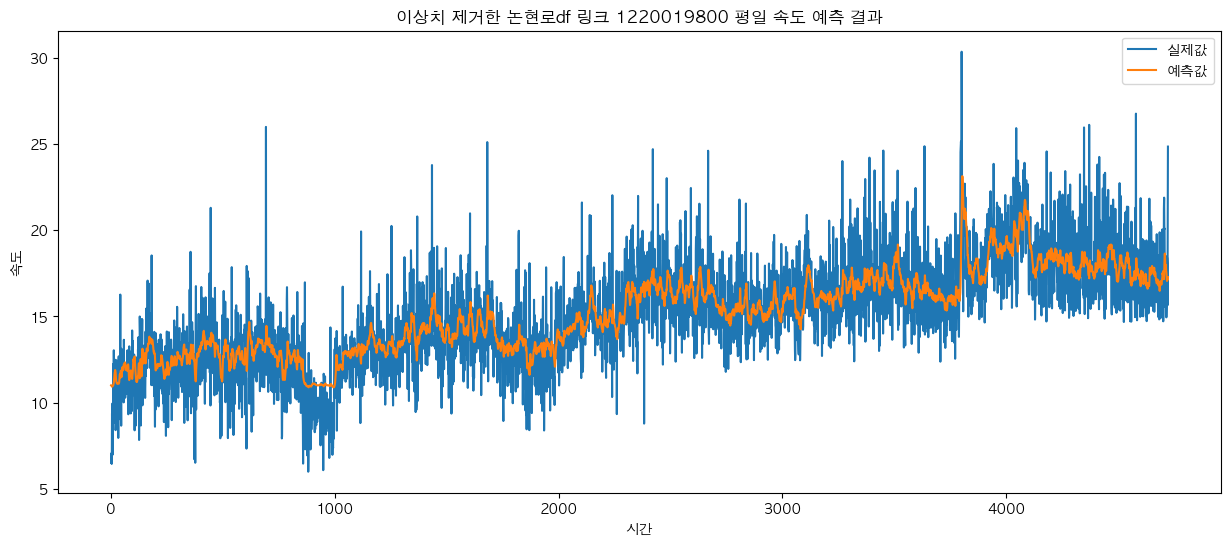


휴일 데이터 분석 중... (데이터 수: 11328)

휴일 평가 결과:
RMSE: 2.79
MAE: 2.17


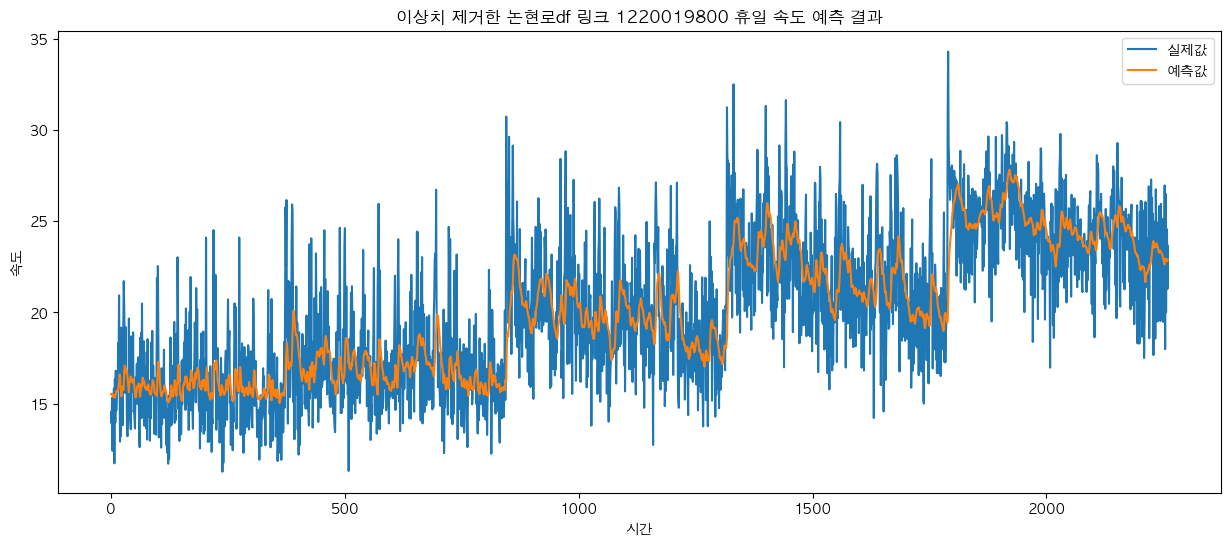


링크아이디 1220029600에 대한 분석

평일 데이터 분석 중... (데이터 수: 23719)

평일 평가 결과:
RMSE: 2.14
MAE: 1.62


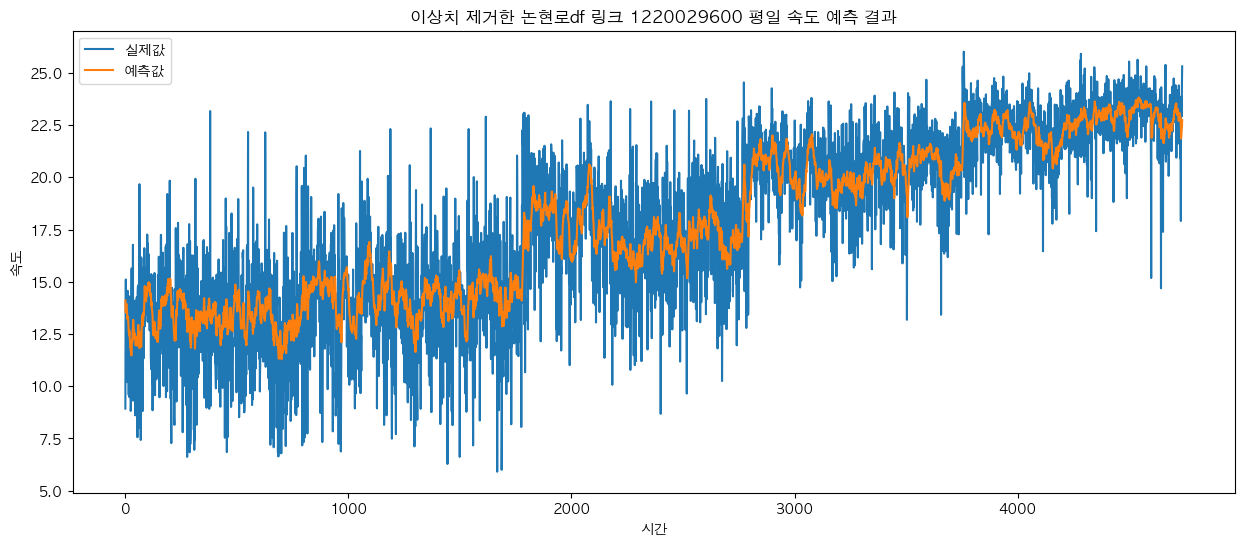


휴일 데이터 분석 중... (데이터 수: 11328)

휴일 평가 결과:
RMSE: 2.33
MAE: 1.72


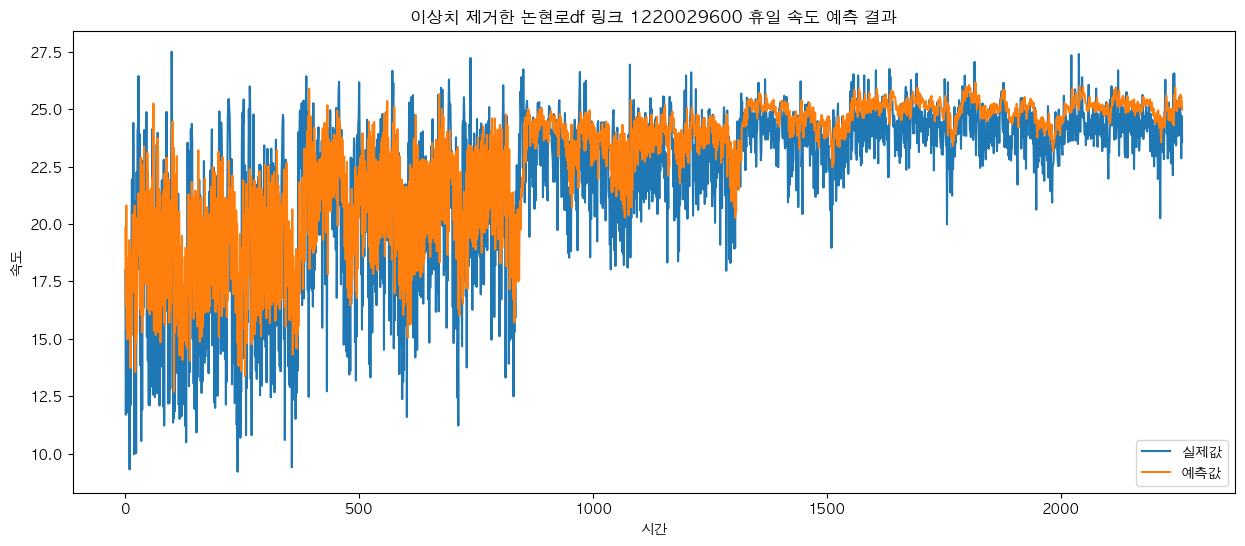

In [18]:
def train_lstm_model_with_holiday(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    평일/휴일을 구분하여 LSTM 모델을 학습하고 예측하는 함수
    """
    # 평일/휴일 구분 조건 추가
    df['is_weekend_holiday'] = ((df['요일'].isin(['토', '일'])) | (df['isHoliday'] == 1)).astype(int)
    
    # 지정된 링크 아이디만 분석
    unique_links = [1220022900, 1220019800, 1220029600]
    results = {}
    predictions_df = pd.DataFrame()
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id].copy()
        
        # 평일/휴일 구분
        weekday_df = link_df[link_df['is_weekend_holiday'] == 0]
        holiday_df = link_df[link_df['is_weekend_holiday'] == 1]
        
        for data_type, data in [("평일", weekday_df), ("휴일", holiday_df)]:
            if len(data) < time_steps + 1:
                print(f"{data_type} 데이터가 부족하여 건너뜁니다.")
                continue
                
            print(f"\n{data_type} 데이터 분석 중... (데이터 수: {len(data)})")
            
            # 데이터 전처리
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(data[target_col].values.reshape(-1,1))

            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(len(scaled_data) - time_steps):
                X.append(scaled_data[i:(i + time_steps), 0])
                y.append(scaled_data[i + time_steps, 0])
            X, y = np.array(X), np.array(y)

            # 학습/테스트 데이터 분할
            train_size = int(len(X) * train_ratio)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # LSTM 입력 형태로 reshape
            X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))
            X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

            # LSTM 모델 구성
            model = Sequential([
                LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
                LSTM(50, activation='relu'),
                Dense(1)
            ])

            model.compile(optimizer='adam', loss='mse')

            # 모델 학습
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                              validation_split=0.1, verbose=0)

            # 24시간 미래 예측
            last_sequence = scaled_data[-time_steps:]
            future_predictions = []
            
            current_sequence = last_sequence.reshape((1, time_steps, 1))
            for _ in range(24):
                next_pred = model.predict(current_sequence, verbose=0)
                future_predictions.append(next_pred[0,0])
                current_sequence = np.roll(current_sequence, -1)
                current_sequence[0,-1,0] = next_pred[0,0]
            
            future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
            
            # 예측 결과를 DataFrame에 추가
            temp_df = pd.DataFrame({
                '링크아이디': [link_id] * 24,
                'hour': range(24),
                '예측속도': future_predictions.flatten(),
                '구분': [data_type] * 24
            })
            predictions_df = pd.concat([predictions_df, temp_df])

            # 모델 평가 및 시각화
            y_test_pred = model.predict(X_test, verbose=0)
            
            # 평가 지표 계산
            mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), 
                                   scaler.inverse_transform(y_test_pred))
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), 
                                    scaler.inverse_transform(y_test_pred))
            
            print(f"\n{data_type} 평가 결과:")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAE: {mae:.2f}")

            # 결과 시각화
            plt.figure(figsize=(15,6))
            plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='실제값')
            plt.plot(scaler.inverse_transform(y_test_pred), label='예측값')
            plt.title(f'{name} 링크 {link_id} {data_type} {target_col} 예측 결과')
            plt.xlabel('시간')
            plt.ylabel(target_col)
            plt.legend()
            plt.show()

    # 예측 결과를 CSV 파일로 저장
    predictions_df.to_csv(f'{name}_이상치제거_평일휴일구분_{target_col}_predictions.csv', index=False)
    return predictions_df

# 모델 실행
predictions = train_lstm_model_with_holiday(nonhyun_df_clean, '이상치 제거한 논현로df', target_col='속도')